# MIS 583 Assignment 4: Deep Fashion

**Your Answer:**   
Hi I'm 李畇彤, M114020038

## Multitask Learning
根據衣服圖片，建立一個 Multitask Learning 的模型，同時預測出種類與屬性。
### Task 1 : Category
- Multiclass : 10 categories
- Goal : Predict the categories(0~9) of the outfit, a total of 10 categories.
- [Kaggle link](https://www.kaggle.com/competitions/mis583-2022-deep-fashion-1/leaderboard)

### Task 2 : Attribute
- Multilabel : 15 attributes
- Goal：Predict the attributes(0~14) of the outfit, a total of 15 attributes, each outfit could have many attributes (>=1).
- [Kaggle link](https://www.kaggle.com/competitions/mis583-2022-a4-deep-fashion-2/leaderboard)

## Google Colab Setup

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

We use `python==3.7.14`, `torch==1.12.1+cu113` and `torchvision==0.13.1+cu113`. This is the default version in Google Colab.

In [9]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.7.15 (default, Oct 12 2022, 19:14:55) 
torch 1.12.1+cu113
torchvision 0.13.1+cu113


# Prepare Data

## Unzip Data


In [10]:
!unzip -qq ./drive/MyDrive/NSYSU/Deep_Learning/MIS583/deep_fashion.zip

In [11]:
data_folder = 'deep_fashion'

## Loading the dataset


### Custom dataset
繼承自定義資料集的框架 `torch.utils.data.Dataset`，主要實現 `__getitem__()` 和 `__len__()` 這兩個方法。

常使用來做到設定資料位址、設定讀取方式、子資料集的標籤和轉換條件...等。

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

In [12]:
import csv
import os
import numpy as np
from PIL import Image
import torch

class Fashion(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.category_labels = []
        self.attribute_labels = []
        self.transform = transform
        
        with open(f'{data_folder}/{csv_file}', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(f"{row['file_path']}")
                if mode != 'test':
                    self.category_labels.append(row['category_label'])
                    self.attribute_labels.append(list(map(int, row['attribute_label'].split())))

    def __getitem__(self, index):
        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)
        if self.mode == 'test':
            return data
        category_label = torch.tensor(int(self.category_labels[index]))

        attribute_label = torch.tensor(self.attribute_labels[index])
        attribute_label = torch.zeros(15).scatter_(0, attribute_label, 1)

        return data, category_label, attribute_label

    def __len__(self):
        return len(self.data_list)

### Data augmentation 

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

PyTorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/vision/stable/transforms.html)

**NOTICE**: There are some operations may not be necessary for predict, so we should write one for train and one for others.

In [13]:
from torchvision import transforms
# For TRAIN
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-90, 90)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
  ])

# For VAL, TEST
transforms_test = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
  ])

### Instantiate dataset

Let's instantiate three `Fashion` class.
+ dataset_train: for training.
+ dataset_val: for validation.
+ dataset_test: for tesing.


### Data Quality
+ train : 39092 
+ val : 5528
+ test : 11225

In [14]:
dataset_train = Fashion('train.csv', mode='train', transform=transforms_train)
dataset_val = Fashion('val.csv', mode='val', transform=transforms_test)
dataset_test = Fashion('test.csv', mode='test', transform=transforms_test)

In [15]:
print("The first image's shape in dataset_train :", dataset_train[0][0].size())
print("There are", dataset_train.__len__(), "images in dataset_train.")

The first image's shape in dataset_train : torch.Size([3, 224, 224])
There are 39092 images in dataset_train.


### `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [16]:
from torch.utils.data import DataLoader

batch_size = 32
num_workers = 2
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers, shuffle=False)

Finally! We have made all data prepared.  
Let's go develop our model.

# Implement CNN using PyTorch

### Define a Convolutional Neural Network

Try to design and train a deep convolutional network from scratch to predict the class label of a flower image. 

You can refer to last assignment about image_classifier, and try to go deep and use more method for better model.

In [17]:
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.models as models


class Mtl_Model(nn.Module): 
    def __init__(self): 
        super().__init__()
        # using model pretraining (vgg16, googlenet, resnet18, resnet34, resnet101 ...)
        self.model = models.vgg16(pretrained=True)

        # Category Model
        self.fc1 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(1000, 10)) # ResNet pretrain 的 fc size = 1000，所以 set linear = 1000
        
        # Attribute Model
        self.fc2 = nn.Sequential(
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1000, 15))


    def forward(self, x): 
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        x = self.model(x)
          
        out1 = self.fc1(x)
        out2 = self.fc2(x)

        return out1, out2


In [18]:
device = torch.device('cuda')
# or
#device = torch.device('cpu')

In [19]:
model = Mtl_Model()
model = model.to(device)
print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Mtl_Model(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

We have made our model!  
Next, PyTorch also provide many utility function(loss, optmizer...etc).  
You can define them in one-line.

### Define loss and optimizer

In [20]:
import torch.nn as nn
import torch.optim as optim

# Category -> CrossEntropyLoss, Attribute -> BCELoss
criterion1, criterion2 = nn.CrossEntropyLoss(), nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

criterion1 = criterion1.to(device)
criterion2 = criterion2.to(device)

### Train the model

#### Train function
Let's define train function.  
It will iterate input data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

In [21]:
from sklearn.metrics import f1_score


In [22]:
def train(input_data, model, criterion1, criterion2, optimizer):

    model.train()
    loss_list = []
    attr_pred_list = []
    attr_true_list = []
    total_count = 0
    acc_count = 0

    for i, data in enumerate(input_data, 0):
        inputs = data[0].to(device)
        category_labels = data[1].to(device)
        attribute_labels = data[2].to(device)


        optimizer.zero_grad()
        category_out, attribute_out = model(inputs)

        category_loss = criterion1(category_out, category_labels)
        attribute_loss = criterion2(attribute_out, attribute_labels)
        loss = category_loss * 1 + attribute_loss * 8
        loss.backward()
        optimizer.step()

        _, category_predict = torch.max(category_out.data, dim=1)
        attribute_predict = (attribute_out.data > 0.5).int()
        attr_pred_list += attribute_predict.tolist()
        attr_true_list += attribute_labels.int().tolist()
        total_count += category_labels.size(0) # 加總category每個批次的大小
        acc_count += (category_predict == category_labels).sum().item() # 加總category每個批次的預測準確率
        loss_list.append(loss.item())

    acc = acc_count / total_count
    f1 = f1_score(attr_true_list, attr_pred_list, average='samples')
    loss = sum(loss_list) / len(loss_list)
    
    return acc, f1, loss

#### Validate function
Next part is validate function.  
It works as training function without optmizer and weight-updating part.

In [23]:
def val(input_data, model, criterion1, criterion2):
    model.eval()
    loss_list = []
    attr_pred_list = []
    attr_true_list = []
    total_count = 0
    acc_count = 0

    with torch.no_grad():
        for i, data in enumerate(input_data, 0):
            inputs = data[0].to(device)
            category_labels = data[1].to(device)
            attribute_labels = data[2].to(device)


            category_out, attribute_out = model(inputs)
            category_loss = criterion1(category_out, category_labels)
            attribute_loss = criterion2(attribute_out, attribute_labels)
            loss = category_loss * 1 + attribute_loss * 8
            
            _, category_predict = torch.max(category_out.data, dim=1)
            attribute_predict = (attribute_out.data > 0.5).int()
            attr_pred_list += attribute_predict.tolist()
            attr_true_list += attribute_labels.int().tolist()
            total_count += category_labels.size(0)
            acc_count += (category_predict == category_labels).sum().item()
            loss_list.append(loss.item())
        
    acc = acc_count / total_count
    f1 = f1_score(attr_true_list, attr_pred_list, average='samples')
    loss = sum(loss_list) / len(loss_list)

    return acc, f1, loss

#### Training in a loop
Call train and test function in a loop.  
Take a break and wait.

In [24]:
max_epochs = 20
log_interval = 1 # print acc and loss in per log_interval time

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
train_f1_list = []
val_f1_list = []

for epoch in range(1, max_epochs + 1):
    train_acc, train_f1, train_loss = train(train_loader, model, criterion1, criterion2, optimizer)
    val_acc, val_f1, val_loss = val(val_loader, model, criterion1, criterion2)
    scheduler.step()

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    train_f1_list.append(train_f1)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    val_f1_list.append(val_f1)

    if epoch % log_interval == 0:
        print('=' * 40, 'Epoch', epoch, '=' * 40)
        print('Train Acc (Category): {:.6f} Train F1 (Attribute): {:.6f} Train Loss: {:.6f}'.format(train_acc, train_f1, train_loss))
        print(' Val Acc (Category): {:.6f}  Val F1 (Attribute): {:.6f}  Val Loss: {:.6f}'.format(val_acc, val_f1, val_loss))

======================================== Epoch 1 ========================================
Train Acc (Category): 0.348869 Train F1 (Attribute): 0.066136 Train Loss: 4.038790
 Val Acc (Category): 0.475760  Val F1 (Attribute): 0.130921  Val Loss: 3.471590
======================================== Epoch 2 ========================================
Train Acc (Category): 0.474701 Train F1 (Attribute): 0.129991 Train Loss: 3.470651
 Val Acc (Category): 0.502171  Val F1 (Attribute): 0.172899  Val Loss: 3.280924
======================================== Epoch 3 ========================================
Train Acc (Category): 0.522920 Train F1 (Attribute): 0.170472 Train Loss: 3.259797
 Val Acc (Category): 0.539797  Val F1 (Attribute): 0.193048  Val Loss: 3.198995
======================================== Epoch 4 ========================================
Train Acc (Category): 0.550522 Train F1 (Attribute): 0.193406 Train Loss: 3.125312
 Val Acc (Category): 0.571997  Val F1 (Attribute): 0.225036  Val Los

In [25]:
# save your well-trained state_dict of model
torch.save(model.state_dict(), 'NAME_OF_THIS_EXPERIMENT.pt')

#### Visualize accuracy and loss

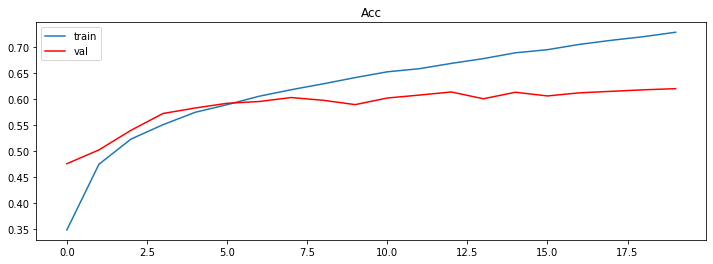

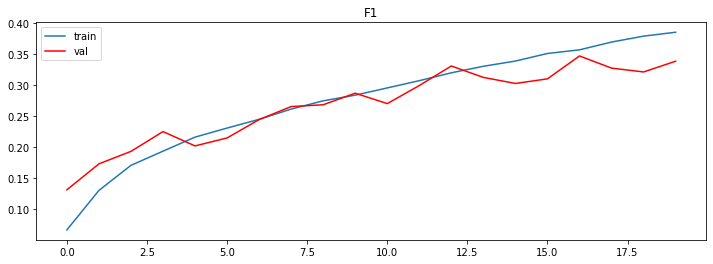

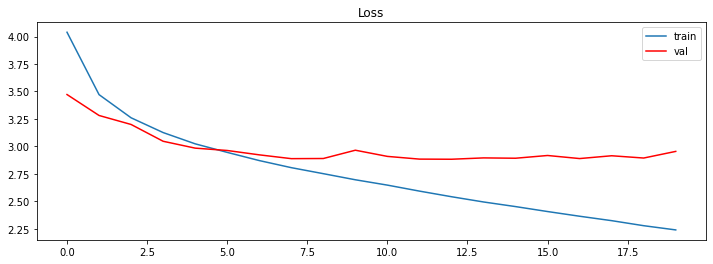

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_f1_list)), train_f1_list)
plt.plot(range(len(val_f1_list)), val_f1_list, c='r')
plt.legend(['train', 'val'])
plt.title('F1')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()

### Predict Result

Predict the labesl based on testing set. Upload to Kaggle. [**LINK**](https://www.kaggle.com/t/a9e78aa7a68b40cd960bd8dcb09f8e45).

**How to upload**

1. Click the folder icon in the left hand side of Colab.
2. Right click "result.csv". Select "Download"
3. To kaggle. Click "Submit Predictions"
4. Upload the result.csv
5. System will automaticlaly calculate the accuracy of 70% dataset and publish this result to leaderboard.

---

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/t/a9e78aa7a68b40cd960bd8dcb09f8e45)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中70%資料的正確率

In [27]:
from google.colab import files

In [28]:
def predict_category(input_data, model):
  model.eval()
  output_list = []
  with torch.no_grad():
    for data in input_data:
      images = data.to(device)
      outputs = model(images)[0]
      _, predicted = torch.max(torch.softmax(outputs.data, 1), 1)
      output_list.extend(predicted.to('cpu').numpy().tolist())
  return output_list

In [29]:
idx = 0
output_csv = predict_category(test_loader, model)
with open('result_category.csv', 'w', newline='') as csvFile:
  writer = csv.DictWriter(csvFile, fieldnames=['file_path', 'category_label'])
  writer.writeheader()
  for result in output_csv:
    file_path = dataset_test.data_list[idx]
    writer.writerow({'file_path':file_path, 'category_label':result})
    idx += 1

In [30]:
def predict_attribute(input_data, model):
  model.eval()
  output_list = []
  with torch.no_grad():
    for data in input_data:
      images = data.to(device)
      outputs = model(images)[1]
      predicted = (torch.sigmoid(outputs.data) > 0.25).int()
      index = []
      for img in range(len(predicted)):
        index = []
        for i in range(len(predicted[img])):
            if(predicted[img][i]==1):
                index.append(str(i))
        output_list.append(' '.join(index)) #轉成str
  return output_list

In [31]:
idx = 0
output_csv = predict_attribute(test_loader, model)
with open('result_attribute.csv', 'w', newline='') as csvFile:
  writer = csv.DictWriter(csvFile, fieldnames=['file_path', 'attribute_label'])
  writer.writeheader()
  for result in output_csv:
    file_path = dataset_test.data_list[idx]
    writer.writerow({'file_path':file_path, 'attribute_label':result})
    idx += 1

In [32]:
files.download("result_category.csv")
files.download("result_attribute.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Keep trying and write report

Keep adjust your model, loss function, optimizer...... to train the better model.  
Remember record the output of different setting. It's convenient for your to write the report.

You are on your way!

---

持續調整模型、訓練方法、損失函數、優化器等，來訓練出更好的模型，並記錄使用不同參數得出的效果，以利後續 Report 的撰寫。

大家加油！